<h1> <center><font color='green' > <b>AGN Image Classification for SDSS</b></font> </center></h1>

# Model Performance Evaluation
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
SDSS Version: DR8

# Import

In [17]:
# System
import os
import glob
from tqdm import tqdm
import h5py
from IPython.display import Markdown, display, Audio

# Web Scraping

# Data Analysis
import pandas as pd
import numpy as np

# Machine Learning
from scipy import stats
import sklearn
import joblib
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from tensorflow import keras
import keras.backend as K

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

# Functions

In [2]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [3]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [5]:
def load_dataset(train_file, dev_file):
    train_dataset = h5py.File(train_file, "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    dev_dataset = h5py.File(dev_file, "r")
    dev_set_x_orig = np.array(dev_dataset["dev_set_x"][:]) # your test set features
    dev_set_y_orig = np.array(dev_dataset["dev_set_y"][:]) # your test set labels

    #classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    dev_set_y_orig = dev_set_y_orig.reshape((1, dev_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, dev_set_x_orig, dev_set_y_orig

In [4]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(3,3))
    sns.set(font_scale=1.5) 
    ax = sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    ax.set(xlabel='Predicted Values', ylabel='Actual Value')
    plt.show()
    

# Read train/dev/test sets

In [7]:
# Image directory
Image_path = '/data/blackbase/Images/'

# datasets
train_file = Image_path+'train_sdss.h5'
dev_file = Image_path+'dev_sdss.h5'

In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset(train_file, dev_file)

In [14]:
y_train = Y_train_orig.T
y_dev = Y_test_orig.T

In [15]:
# Set star = galaxy = 1
y_train = np.where(y_train == 2, 1, y_train)
y_dev = np.where(y_dev == 2, 1, y_dev)

# Read results

In [13]:
# Shallow CNN
%store -r yhat_train_cnn
%store -r yhat_dev_cnn
%store -r yhat_dev_prob_cnn
%store -r yhat_train_prob_cnn

# ResNet
%store -r yhat_train_res
%store -r yhat_dev_res
%store -r yhat_dev_prob_res
%store -r yhat_train_prob_res

# Model Evaluation

## Metrics
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial

- <font color='green'>AGN completeness (True Positive Rate/recall) </font>: 
    - TP/(TP+FN)
    - measures the proportion of AGN that are correctly identified
- <font color='green'>non-AGN completeness (True Negative Rate/Specificity)</font>: 
    - TN/(TN+FP)
    - measures the proportion of non-AGN that are correctly identified
- <font color='green'>F1 score (Major Metric)</font>: 
    - The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.
    - Notice the label for agn is 0.
- <font color='green'>Accuracy</font>: 
    - It is defined as 0.5x(Recall+Sensitivity)
- <font color='green'>ROC AUC</font>


### Evaluate on Validation Set

In [18]:
# Shallow CNN
f1_dev_cnn = f1_score(y_dev, yhat_dev_cnn, pos_label = 0)
recall_dev_cnn = recall_score(y_dev, yhat_dev_cnn, pos_label = 0)
spec_dev_cnn = recall_score(y_dev, yhat_dev_cnn, pos_label=1)
acc_dev_cnn = accuracy_score(y_dev, yhat_dev_cnn)
auc_dev_cnn = roc_auc_score(y_dev, yhat_dev_cnn)

# ResNet
f1_dev_res = f1_score(y_dev, yhat_dev_res, pos_label = 0)
recall_dev_res = recall_score(y_dev, yhat_dev_res, pos_label = 0)
spec_dev_res = recall_score(y_dev, yhat_dev_res, pos_label=1)
acc_dev_res = accuracy_score(y_dev, yhat_dev_res)
auc_dev_res = roc_auc_score(y_dev, yhat_dev_res)

### Evaluate on Training Set

In [19]:
# Shallow CNN
f1_train_cnn = f1_score(y_train, yhat_train_cnn, pos_label = 0)
recall_train_cnn = recall_score(y_train, yhat_train_cnn, pos_label = 0)
spec_train_cnn = recall_score(y_train, yhat_train_cnn, pos_label=1)
acc_train_cnn = accuracy_score(y_train, yhat_train_cnn)
auc_train_cnn = roc_auc_score(y_train, yhat_train_cnn)

# ResNet
f1_train_res = f1_score(y_train, yhat_train_res, pos_label = 0)
recall_train_res = recall_score(y_train, yhat_train_res, pos_label = 0)
spec_train_res = recall_score(y_train, yhat_train_res, pos_label=1)
acc_train_res = accuracy_score(y_train, yhat_train_res)
auc_train_res = roc_auc_score(y_train, yhat_train_res)

In [24]:
metric_data = np.array((['Shallow Network', 'Train', recall_train_cnn, spec_train_cnn, f1_train_cnn, acc_train_cnn, 1-acc_train_cnn, auc_train_cnn],
                        ['Shallow Network', 'Validation',recall_dev_cnn, spec_dev_cnn, f1_dev_cnn, acc_dev_cnn, 1-acc_dev_cnn, auc_dev_cnn],
                        ['ResNet', 'Train', recall_train_res, spec_train_res, f1_train_res, acc_train_res, 1-acc_train_res, auc_train_res],
                        ['ResNet', 'Validation',recall_dev_res, spec_dev_res, f1_dev_res, acc_dev_res, 1-acc_dev_res, auc_dev_res]))

df_scores = pd.DataFrame(metric_data, 
            columns=['Algorithm', 'Set', 'AGN completeness', 'non-AGN completeness', 
                     'F1-score', 'Accuracy', 'Error', 'ROC AUC'])
for col in df_scores.columns.values:
    if col != 'Algorithm' and col != 'Set':
        df_scores[col] = df_scores[col].astype(float)

In [25]:
df_scores.to_csv('./results/scores.csv', index=False)

In [26]:
df_scores = pd.read_csv('./results/scores.csv')

In [27]:
df_scores

,Algorithm,Set,AGN completeness,non-AGN completeness,F1-score,Accuracy,Error,ROC AUC
0,Shallow Network,Train,0.98,0.78,0.89,0.88,0.12,0.88
1,Shallow Network,Validation,0.91,0.65,0.80,0.77,0.23,0.78
2,ResNet,Train,0.82,0.98,0.89,0.90,0.10,0.90
3,ResNet,Validation,0.72,0.92,0.80,0.82,0.18,0.82


## Confusion Matrix

In [34]:
con_mat.shape

(2, 2)

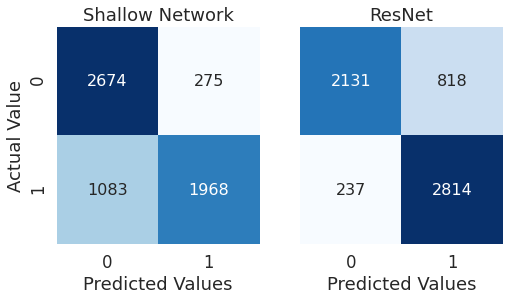

In [44]:
figure, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,4))

con_mat = confusion_matrix(y_dev,yhat_dev_cnn) 
sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, ax=axes[0])
con_mat = confusion_matrix(y_dev,yhat_dev_res) 
sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False, ax=axes[1])


axes[0].set(xlabel='Predicted Values', ylabel='Actual Value')
axes[1].set(xlabel='Predicted Values')


axes[0].set_title("Shallow Network")
axes[1].set_title("ResNet")

plt.savefig('./results/Confusion_matrix.pdf',dpi=300)
plt.show()

### ROC Curve
see https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

In [45]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for name, y_hat in {'Shallow Network':yhat_dev_prob_cnn, 
                    'ResNet':yhat_dev_prob_res}.items():
    fpr, tpr, _ = roc_curve(y_dev,  y_hat)
    auc = roc_auc_score(y_dev, y_hat)
    result_table = result_table.append({'classifiers':name,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

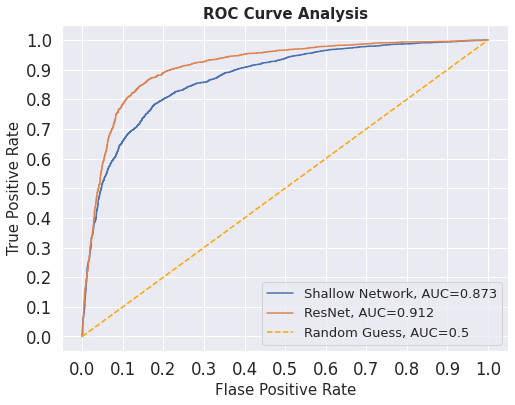

In [46]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(result_table.loc[i]['classifiers'], result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--', label="Random Guess, AUC=0.5")

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.savefig('./results/ROC.pdf',dpi=300)
plt.show()

In [47]:
result_table

,classifiers,fpr,tpr,auc
0,Shallow Network,"[0.0, 0.0, 0.0, 0.00033909799932180403, 0.0003...","[0.0, 0.00032776138970829236, 0.00688298918387...",0.87
1,ResNet,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000339097999321804...","[0.0, 0.00032776138970829236, 0.00426089806620...",0.91


# Result

<font color='blue'>Conclusion:</font>
- The use of deep network makes the performance better than using shallow network with 1 hidden layer (82% vs. 77% accuracy in test set).
- The ResNet tends to misclassify AGN as non-AGN, and shallow network tends to misclassify non-AGN as AGN. 
    
<font color='blue'>Possible Improvement:</font>
- The accuracy of training set is ~ 90%, and testing set is ~ 80%, indicating both bias and variance problem. 
- Get more data.